In [1]:
#Importa os pacotes principais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
#Carrega o dataset
df = pd.read_csv('train.csv')

In [3]:
df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
df['ID'].count()

76020

In [5]:
#Temos uma distribuição bastante heterogênea, com predominância de TARGET 0
df.groupby('TARGET').size()

TARGET
0    73012
1     3008
dtype: int64

In [7]:
#Como a base está muito desbalanceada, precisamos rearranjar sua distribuição. Para isso, vou separar
#duas bases, uma balanceada aleatóriamente e outra com a mesma distribuição da inicial para teste
#final do modelo
dfT0 = df.loc[df['TARGET']==0,:]
dfT1 = df.loc[df['TARGET']==1,:]

dft1train, dfT1test = train_test_split(dfT1, test_size=0.1)
dft0train, dfT0test = train_test_split(dfT0, test_size=0.1)
dft0train = dft0train.sample(frac=0.042)

dfTrain = pd.concat([dft0train,dft1train])
dfTrain = dfTrain.sort_values('ID')

dfTest = pd.concat([dfT0test,dfT1test])

In [8]:
dfTrain.groupby('TARGET').size()

TARGET
0    2760
1    2707
dtype: int64

In [9]:
dfTest.groupby('TARGET').size()

TARGET
0    7302
1     301
dtype: int64

In [17]:
#Separando o dataset de treino
dadosX = dfTrain.iloc[:,1:-1]
dadosY = dfTrain['TARGET'].values
variables = dfTrain.columns[1:-1]

X_testFinal = dfTest.iloc[:,1:-1]
y_testFinal = dfTest['TARGET'].values

- Dado que as colunas são anônimas, a análise exploratória dos dados fica dificultada. Não conseguimos tirar insights dos dados.  
- Como temos muitas dimensões, iremos utilizar técnicas de feature selection

# Feature Selection

- Correlação

In [19]:
#Cálculo de correlação com separação de valores maiores de 0.95
np.set_printoptions(threshold=np.inf)
dfCorrMatrix = np.corrcoef(dadosX, rowvar = False)
dfCorrMatrix = np.nan_to_num(dfCorrMatrix)
dfCorrMatrix[np.where(np.abs(dfCorrMatrix) < 0.95)] = 0.0

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


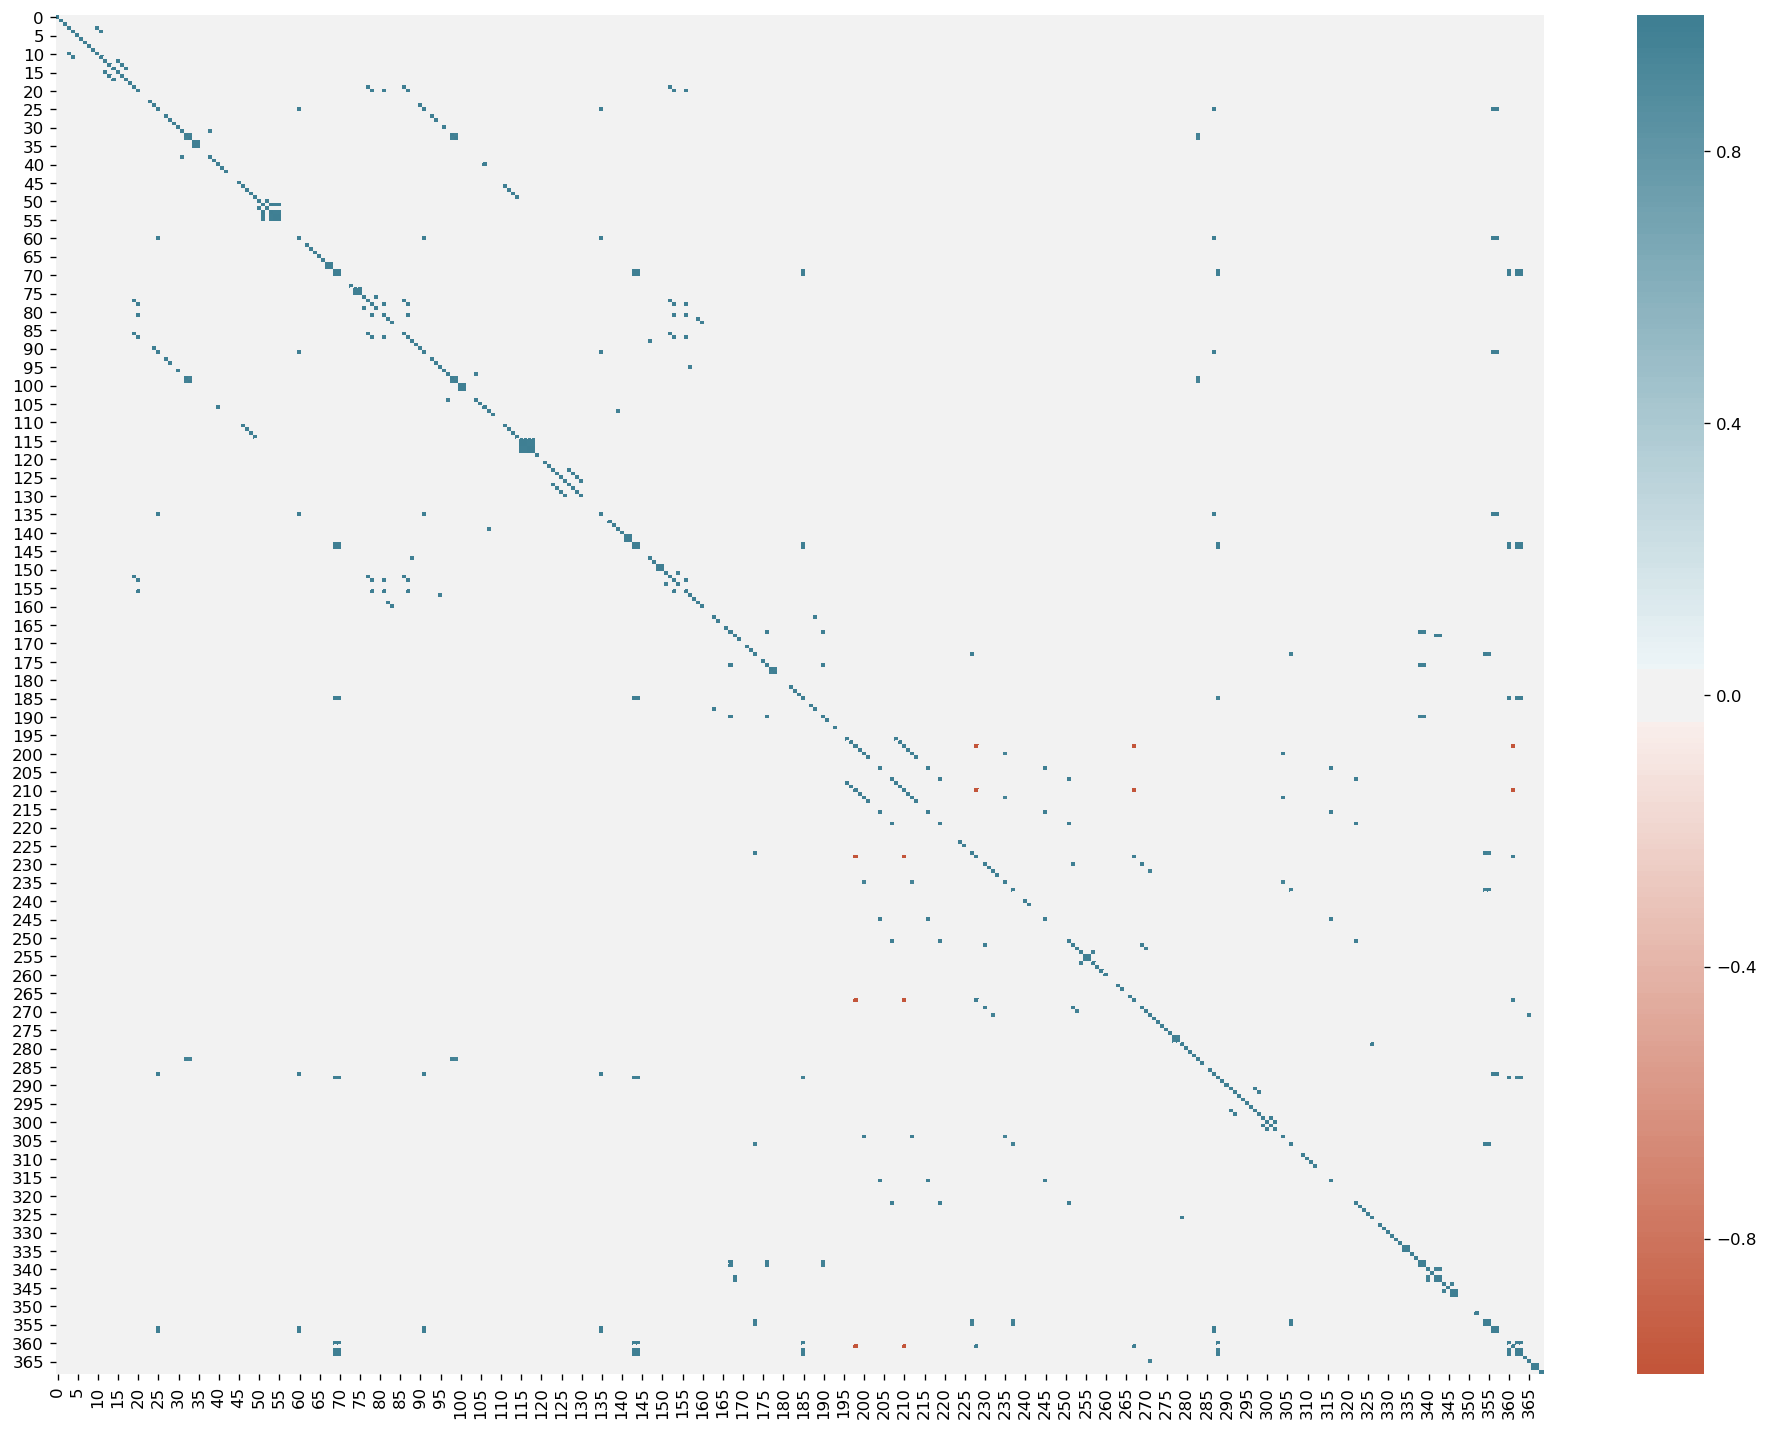

In [20]:
#Muitas variáveis possuem correlação maior que 0.95
fig = plt.figure(figsize=(20, 15), dpi = 120)
corrGrafico = sns.heatmap(
    dfCorrMatrix,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200))

In [21]:
#Removendo as variáveis altamente correlacionadas
fica = []
sai = []
for linha in range(len(dfCorrMatrix)):
    for coluna in range(len(dfCorrMatrix)):
        if dfCorrMatrix[linha,coluna] != 0 and linha != coluna:
            if coluna not in fica:
                sai.append(coluna)
            if linha not in sai:
                fica.append(linha)

In [22]:
print('Um total de %d variáveis foram removidas' % len(set(sai)))
dadosXv1 = dadosX.drop(dadosX.columns[sai], axis=1)
X_testFinalv1 = X_testFinal.drop(X_testFinal.columns[sai], axis=1)

Um total de 112 variáveis foram removidas


In [23]:
dadosXv1.shape

(5467, 257)

- Teste do ChiSquare

In [24]:
from sklearn.feature_selection import chi2

In [25]:
#Calcula a estatística ChiSquare
colunasMantem = list(set(np.where(dadosXv1 < 0)[1]))
dadosX2 = dadosXv1.values
dadosX2[np.where(dadosX2 < 0)] = 0
chitests = chi2(dadosX2,dadosY)

In [26]:
#Filtra valores p maiores que 15% para elimina-los
chitests = np.nan_to_num(chitests)
chiColunas = list(np.where(chitests[1] > 0.15)[0])
chiColunas = [x for x in chiColunas if x not in colunasMantem]

In [27]:
print('Um total de %d variáveis foram removidas' % len(chiColunas))
dadosXv2 = dadosXv1.drop(dadosXv1.columns[chiColunas], axis=1)
X_testFinalv2 = X_testFinalv1.drop(X_testFinalv1.columns[chiColunas], axis=1)

Um total de 21 variáveis foram removidas


In [28]:
dadosXv2.shape

(5467, 236)

- Seleção por árvore de decisão

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [30]:
modelo = RandomForestClassifier()
modelo = modelo.fit(dadosXv2,dadosY)

In [31]:
#Filtrando as importâncias para melhora vizualização
importances = modelo.feature_importances_
indices = np.argsort(importances)
variablesv2 = dadosXv2.columns
ind=[]
for i in indices:
    ind.append(variablesv2[i])

ind = np.asarray(ind)
limite = np.where(importances > 0.0005)[0]
importances = importances[limite]
indices2 = np.argsort(importances)
ind = ind[limite]

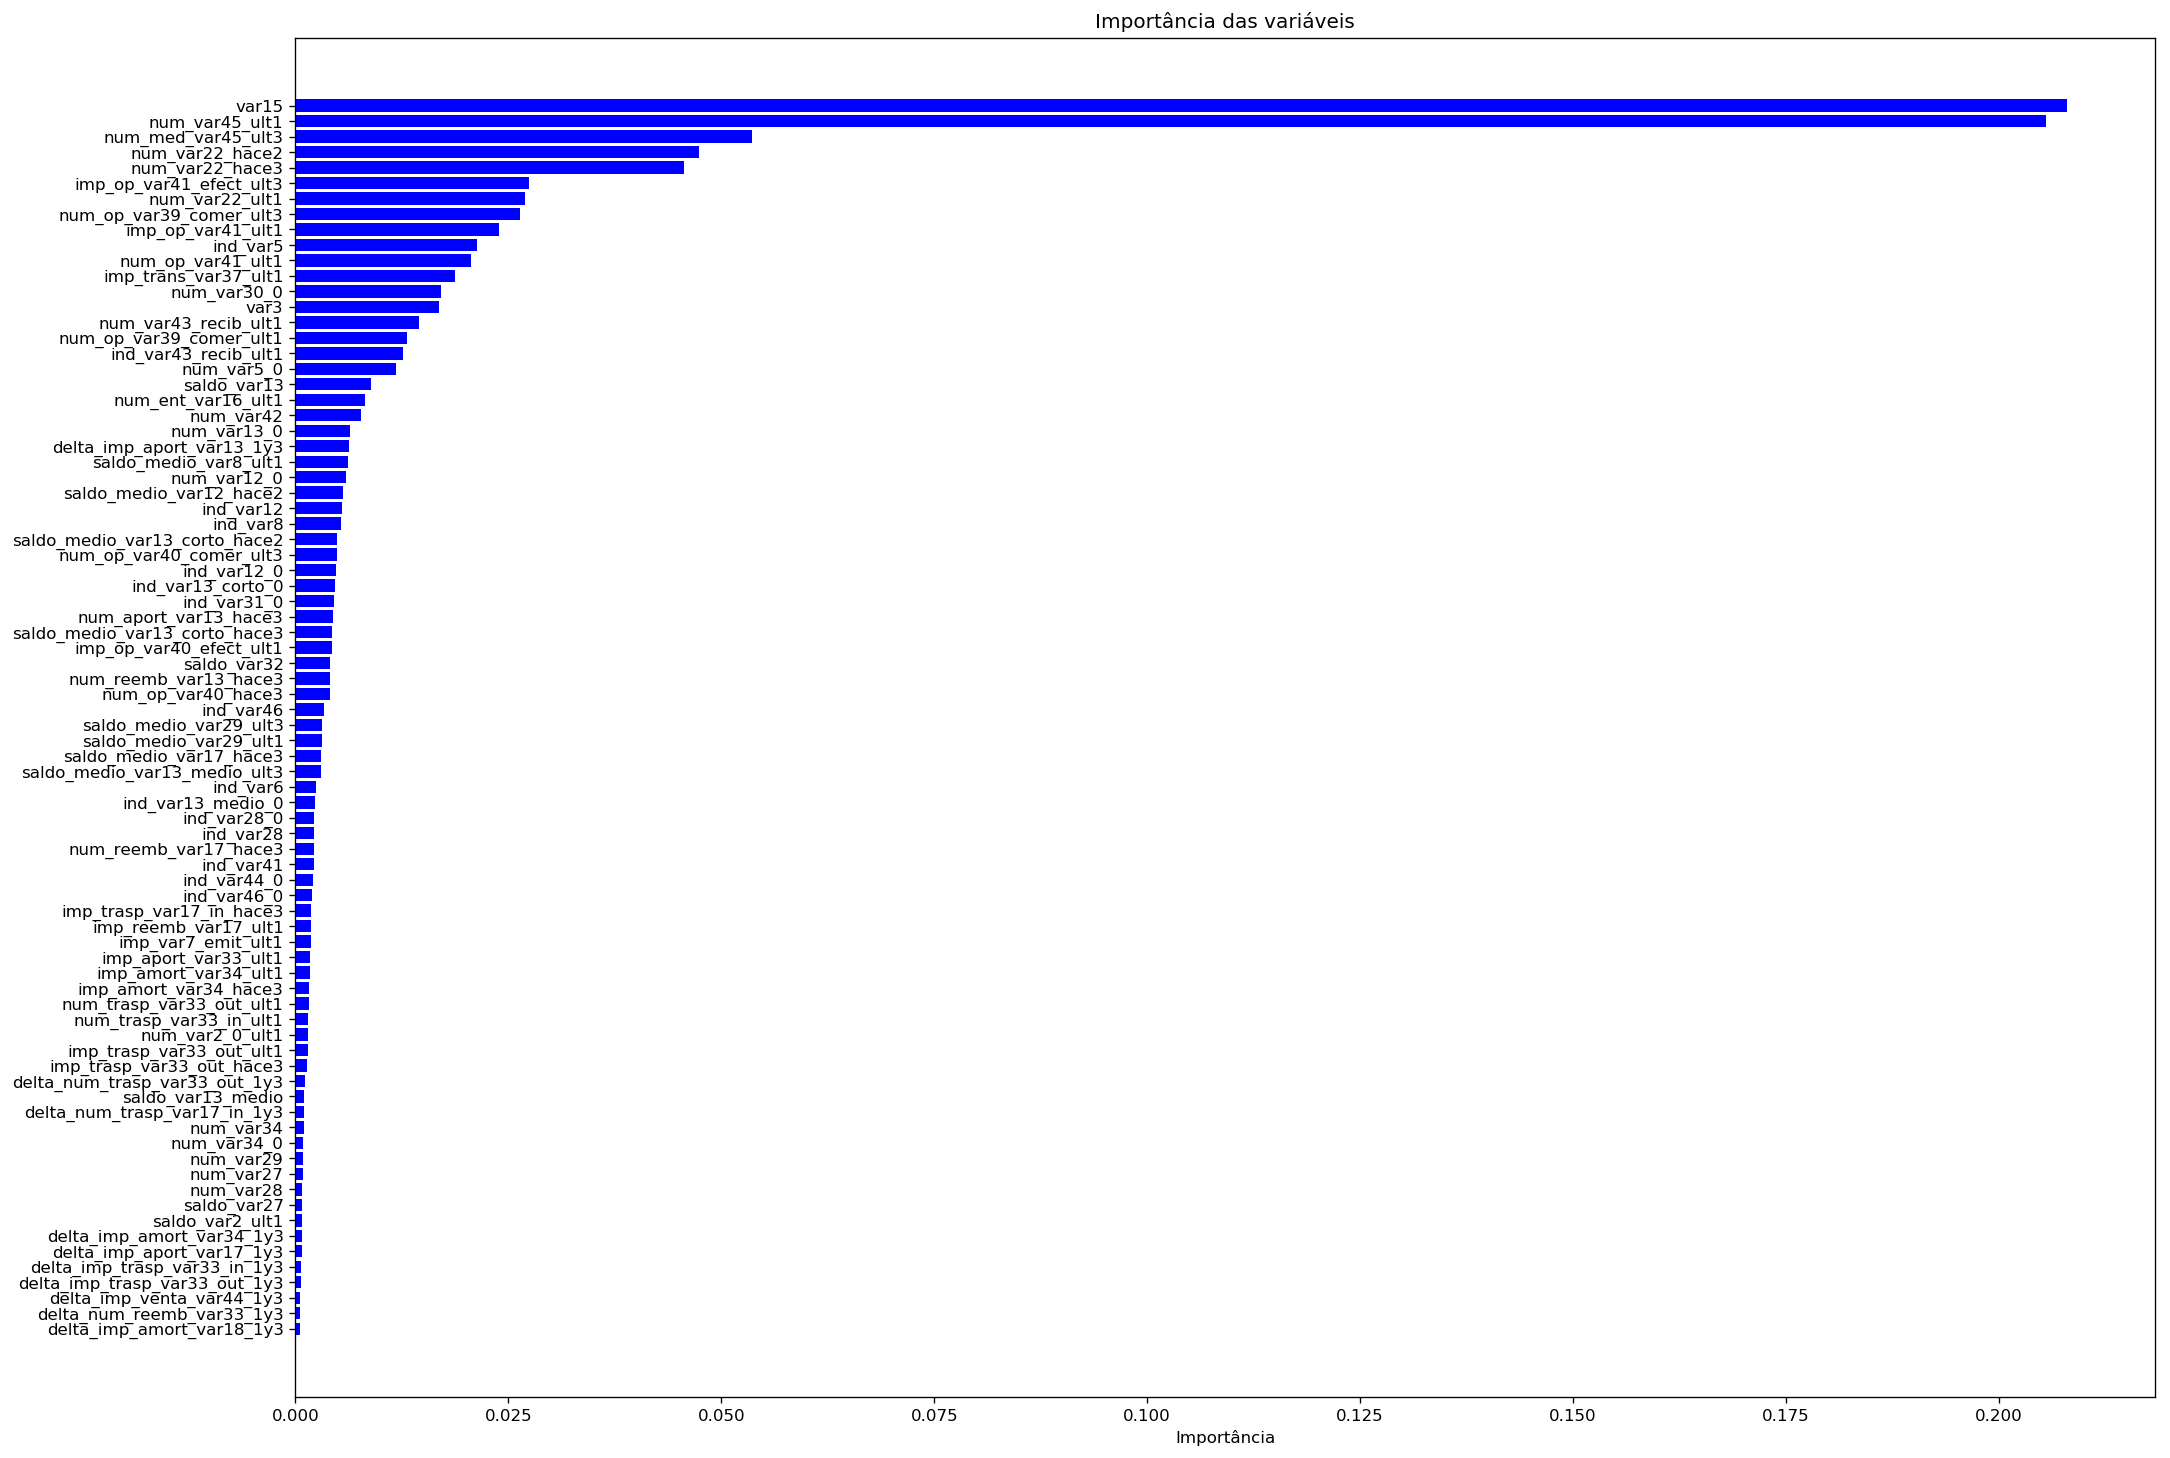

In [32]:
# Plot da Importância das variáveis
fig = plt.figure(figsize=(20, 15), dpi = 120)
plt.title('Importância das variáveis')
plt.barh(range(len(indices2)), importances[indices2], color = 'b', align = 'center')
plt.yticks(range(len(indices2)),ind)
plt.xlabel('Importância')
plt.show()

In [33]:
#Vamos selecionar os 60 melhores features para iniciar a modelagem preditiva e verificar se atendem
#o requerimento mínimo de 70% de acurácia
dadosXv3 = dadosXv2.iloc[:,indices[-61:-1]]
X_testFinalv3 = X_testFinalv2.iloc[:,indices[-61:-1]]

In [34]:
dadosXv3.shape

(5467, 60)

In [35]:
#Dataset que utilizaremos para a modelagem preditiva
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

dadosMP = dadosXv3
dadosMPN = min_max_scaler.fit_transform(dadosMP)
#dadosMPN = preprocessing.scale(dadosMP)

In [36]:
#Importa pacotes para modelagem preditiva
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Modelo preditivo

- Regressão Logística

In [37]:
import statsmodels.api as sm
from sklearn import linear_model

In [38]:
modeloRL_sm=sm.Logit(dadosY,dadosMPN)
modeloRL_smResult=modeloRL_sm.fit()
modeloRL_smResult.summary2()

         Current function value: inf
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                  Logit                Pseudo R-squared:     -inf   
Dependent Variable:     y                    AIC:                  inf    
Date:                   2020-02-13 23:04     BIC:                  inf    
No. Observations:       5467                 Log-Likelihood:       -inf   
Df Model:               58                   LL-Null:              -3789.2
Df Residuals:           5408                 LLR p-value:          1.0000 
Converged:              0.0000               Scale:                1.0000 
No. Iterations:         35.0000                                           
--------------------------------------------------------------------------
       Coef.        Std.Err.      z    P>|z|      [0.025         0.975]   
--------------------------------------------------------------------------
x1       -0.8054        0.5317 -1.5146 0.1299        -1.8476        0.2368
x2       -9.6267        5.4281 -1.7735 0.0761       -20.2656        1.0122
x3  -639734.0910 33216722.9025 -0.0193 0.9846 -65743314.6643 64463846.4823
x4      -17.1009        9.6474 -1.7726 0.0763       -36.0095        1.8078
x5        2.3798        0.8233  2.8906 0.0038         0.7662        3.9934
x6  -103746.2184  5411636.1508 -0.0192 0.9847 -10710358.1713 10502865.7346
x7       -1.7690        1.4760 -1.1985 0.2307        -4.6620        1.1239
x8      -41.5774       10.3208 -4.0285 0.0001       -61.8057      -21.3491
x9   -17287.9876   878851.0115 -0.0197 0.9843  -1739804.3180  1705228.3428
x10      -0.2544        0.3261 -0.7800 0.4354        -0.8935        0.3848
x11       0.3389        0.3200  1.0591 0.2896        -0.2883        0.9661
x12       1.9221        1.0951  1.7552 0.0792        -0.2243        4.0684
x13   19813.7027  3111371.9770  0.0064 0.9949  -6078363.3149  6117990.7202
x14  -51867.6065  2677208.4059 -0.0194 0.9845  -5299099.6612  5195364.4482
x15      -0.8467        1.0081 -0.8399 0.4010        -2.8226        1.1291
x16    6119.1591   958676.1243  0.0064 0.9949  -1872851.5174  1885089.8356
x17      -0.1123        0.1742 -0.6447 0.5191        -0.4537        0.2291
x18       1.0797        5.6640  0.1906 0.8488       -10.0216       12.1811
x19   52987.6684  8320390.7537  0.0064 0.9949 -16254678.5462 16360653.8831
x20       0.1167        1.1632  0.1004 0.9201        -2.1632        2.3966
x21       0.3374        0.2303  1.4650 0.1429        -0.1140        0.7889
x22       7.9673        4.1019  1.9423 0.0521        -0.0724       16.0069
x23      -2.9592        3.4222 -0.8647 0.3872        -9.6666        3.7482
x24      -0.6820        1.0136 -0.6728 0.5011        -2.6686        1.3047
x25     -34.7615     5521.8489 -0.0063 0.9950    -10857.3864    10787.8634
x26      -1.6344        0.8540 -1.9139 0.0556        -3.3082        0.0394
x27       4.4588        2.9531  1.5099 0.1311        -1.3292       10.2468
x28      -6.9594        3.0946 -2.2489 0.0245       -13.0248       -0.8940
x29       0.0668        0.6463  0.1034 0.9177        -1.1999        1.3336
x30       0.7098        1.7134  0.4143 0.6787        -2.6483        4.0679
x31      -7.5832       11.0734 -0.6848 0.4935       -29.2866       14.1202
x32       6.1847        4.7557  1.3005 0.1934        -3.1363       15.5056
x33      -5.1156        2.9976 -1.7066 0.0879       -10.9908        0.7596
x34       1.7231        7.7025  0.2237 0.8230       -13.3735       16.8197
x35  657028.3010 33982169.2021  0.0193 0.9846 -65946799.4516 67260856.0536
x36      -9.4999        6.1978 -1.5328 0.1253       -21.6474        2.6476
x37       1.2132        7.3636  0.1648 0.8691       -13.2193       15.6456
x38       5.4309        8.5237  0.6372 0.5240       -11.2752       22.1369
x39       0.7907        0.4004  1.9746 0.0483         0.0059        1.5755
x40       8.5938        8.6765  0.9905 0.3219        -8.4118       25.5993
x41   

In [39]:
# Montando o modelo
modeloRL = linear_model.LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(dadosMPN, dadosY, test_size=0.3)
modeloRL.fit(X_train,y_train)

# Acurácia
acuracia = cross_val_score(modeloRL, X_train, y_train, cv = 5, scoring = 'roc_auc', n_jobs = -1)
print('Acurácia média: %0.2f' % np.mean(acuracia))

predicoes = modeloRL.predict(X_test)
# Classification report
print(classification_report(y_test, predicoes))
# Confusion Matrix
print(confusion_matrix(y_test, predicoes))

Acurácia média: 0.75
             precision    recall  f1-score   support

          0       0.67      0.72      0.69       787
          1       0.72      0.68      0.70       854

avg / total       0.70      0.70      0.70      1641

[[563 224]
 [273 581]]


- KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
# Divisão dos dados de treino em dados de treino e dados de validação
X_trainSmall, X_valid, y_trainSmall, y_valid = train_test_split(X_train, y_train, test_size = 0.1)

In [42]:
# Range de valores de k que iremos testar
valoresK = range(1, 50, 2)
acuracias = []

In [43]:
# Testando os valores de K
for k in valoresK:
    modeloKNN = KNeighborsClassifier(n_neighbors = k)
    modeloKNN.fit(X_trainSmall, y_trainSmall)

    acuracia = modeloKNN.score(X_valid, y_valid)
    print("k = %d, %.2f%%" % (k, acuracia * 100))
    acuracias.append(acuracia)

k = 1, 57.44%
k = 3, 63.19%
k = 5, 63.71%
k = 7, 63.45%
k = 9, 62.92%
k = 11, 65.01%
k = 13, 65.54%
k = 15, 64.49%
k = 17, 64.23%
k = 19, 63.45%
k = 21, 63.71%
k = 23, 64.49%
k = 25, 63.97%
k = 27, 63.97%
k = 29, 64.49%
k = 31, 63.97%
k = 33, 64.23%
k = 35, 63.19%
k = 37, 63.71%
k = 39, 63.45%
k = 41, 63.45%
k = 43, 63.97%
k = 45, 63.97%
k = 47, 63.45%
k = 49, 63.71%


In [44]:
#Criando o modelo final
maiorK = np.argmax(acuracias)
modeloFinal = KNeighborsClassifier(n_neighbors = valoresK[maiorK])

In [45]:
# Treinamento do modelo
modeloFinal.fit(X_train, y_train)

# Acurácia
acuracia = cross_val_score(modeloFinal, X_train, y_train, cv = 5, scoring = 'roc_auc', n_jobs = -1)
print('Acurácia média: %0.2f' % np.mean(acuracia))

predicoes = modeloFinal.predict(X_test)
# Classification report
print(classification_report(y_test, predicoes))
# Confusion Matrix
print(confusion_matrix(y_test, predicoes))

Acurácia média: 0.74
             precision    recall  f1-score   support

          0       0.66      0.72      0.69       787
          1       0.72      0.66      0.69       854

avg / total       0.69      0.69      0.69      1641

[[568 219]
 [294 560]]


 - Arvore de decisão

In [46]:
modeloRF = RandomForestClassifier(n_estimators=50)
modeloRF.fit(X_train, y_train)

# Acurácia
acuracia = cross_val_score(modeloRF, X_train, y_train, cv = 5, scoring = 'roc_auc', n_jobs = -1)
print('Acurácia média: %0.2f' % np.mean(acuracia))

predicoes = modeloRF.predict(X_test)
# Classification report
print(classification_report(y_test, predicoes))
# Confusion Matrix
print(confusion_matrix(y_test, predicoes))

Acurácia média: 0.73
             precision    recall  f1-score   support

          0       0.64      0.71      0.67       787
          1       0.70      0.63      0.67       854

avg / total       0.67      0.67      0.67      1641

[[557 230]
 [313 541]]


- Árvores de decisão AdaBoost

In [47]:
from sklearn.ensemble import AdaBoostClassifier

In [48]:
modeloAB = AdaBoostClassifier(n_estimators=100)
modeloAB.fit(X_train, y_train)

# Acurácia
acuracia = cross_val_score(modeloAB, X_train, y_train, cv = 5, scoring = 'roc_auc', n_jobs = -1)
print('Acurácia média: %0.2f' % np.mean(acuracia))

predicoes = modeloAB.predict(X_test)
# Classification report
print(classification_report(y_test, predicoes))
# Confusion Matrix
print(confusion_matrix(y_test, predicoes))

Acurácia média: 0.76
             precision    recall  f1-score   support

          0       0.71      0.69      0.70       787
          1       0.72      0.74      0.73       854

avg / total       0.72      0.72      0.72      1641

[[545 242]
 [222 632]]


- Árvores de decisão Gradient Boosting

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

In [50]:
modeloGB = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.2)
modeloGB.fit(X_train, y_train)

# Acurácia
acuracia = cross_val_score(modeloGB, X_train, y_train, cv = 5, scoring = 'roc_auc', n_jobs = -1)
print('Acurácia média: %0.2f' % np.mean(acuracia))

predicoes = modeloGB.predict(X_test)
# Classification report
print(classification_report(y_test, predicoes))
# Confusion Matrix
print(confusion_matrix(y_test, predicoes))

Acurácia média: 0.77
             precision    recall  f1-score   support

          0       0.71      0.73      0.72       787
          1       0.74      0.73      0.74       854

avg / total       0.73      0.73      0.73      1641

[[574 213]
 [234 620]]


Como o modelo de árvore de decisão Gradiente Boosting apresentou o melhor resultado, vamos para a
etapa de tunning dos hyperparameters

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
#Procurando os melhores parâmetros
parameters = {'n_estimators':[10,50,100,150,200],'learning_rate':[0.1,0.2,0.3,0.5],'max_depth':[2,3,5]}
modeloGB = GradientBoostingClassifier()
modeloGBGS = GridSearchCV(modeloGB, parameters, scoring='roc_auc')
modeloGBGS.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 150, 200], 'learning_rate': [0.1, 0.2, 0.3, 0.5], 'max_depth': [2, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [53]:
modeloGBGS.best_score_

0.778629751544058

In [54]:
modeloGBGS.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

In [55]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

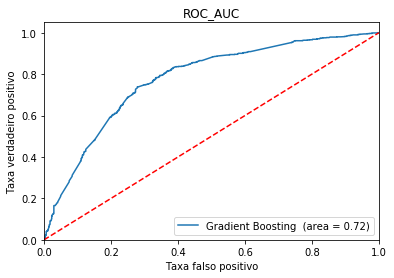

In [56]:
#Montando a roc_auc
GB_roc_auc = roc_auc_score(y_test, modeloGBGS.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, modeloGBGS.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Gradient Boosting  (area = %0.2f)' % GB_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa falso positivo')
plt.ylabel('Taxa verdadeiro positivo')
plt.title('ROC_AUC')
plt.legend(loc="lower right")
plt.show()

In [57]:
#Por último, iremos utilizar a base de teste final, com dados nunca vistos pelo modelo e 
#que possue a mesma distribuição inicial do dataset
predicoes = modeloGBGS.predict(X_testFinalv3)
# Classification report
print(classification_report(y_testFinal, predicoes))
# Confusion Matrix
print(confusion_matrix(y_testFinal, predicoes))

             precision    recall  f1-score   support

          0       0.96      0.85      0.90      7302
          1       0.05      0.18      0.08       301

avg / total       0.93      0.83      0.87      7603

[[6237 1065]
 [ 247   54]]


In [ ]:
#Quando o teste é feito mantendo a distribuição inicial, o número de falsos positivos cresce muito